# Классификация изображений

In [ ]:
!nvidia-smi

Thu Feb 25 02:35:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"stanislavnevezhin","key":"796e4c3e37b934f1c01f4d8ad5aef256"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c sf-dl-car-classification

  0% 0.00/78.7k [00:00<?, ?B/s]
100% 78.7k/78.7k [00:00<00:00, 29.3MB/s]
 98% 1.08G/1.11G [00:13<00:00, 54.5MB/s]
100% 1.11G/1.11G [00:14<00:00, 84.3MB/s]
  0% 0.00/196k [00:00<?, ?B/s]
100% 196k/196k [00:00<00:00, 213MB/s]
 97% 475M/489M [00:05<00:00, 54.8MB/s]
100% 489M/489M [00:05<00:00, 85.8MB/s]


In [ ]:
!ls

drive	     sample_data	    test.zip   train.zip
kaggle.json  sample-submission.csv  train.csv


In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")

In [ ]:
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


**Импортируем модули**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choice
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (ModelCheckpoint, Callback, 
                                        EarlyStopping, ReduceLROnPlateau, 
                                        LearningRateScheduler)

from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("/content/"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['.config', 'sample-submission.csv', 'train.csv', 'drive', 'kaggle.json', 'test.zip', 'train.zip', 'sample_data']
Python       : 3.7.10 (default, Feb 20 2021, 21:17:23) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [ ]:
!pip freeze > requirements.txt

## Основные настройки

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 640 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../content/'
PATH = '../working/car/' # рабочая директория
SAVE_PATH = '../content/drive/MyDrive/Colab Notebooks/deep learning/'

In [ ]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH,exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

## EDA / Анализ данных

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [ ]:
print('Распаковываем картинки')
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("/content/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


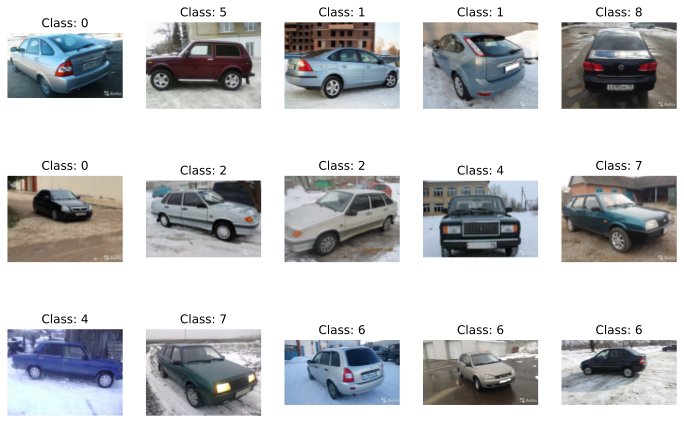

In [ ]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=15)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,5, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

../working/car/train/2/
162605.jpg


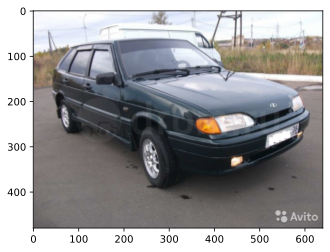

(640, 480)

In [ ]:
random_im_list = PATH+'train/'+str(np.random.randint(10))+'/'
random_im = choice(os.listdir(random_im_list))

print(random_im_list)
print(random_im)
image = PIL.Image.open(random_im_list+random_im)
imgplot = plt.imshow(image)
plt.show()
image.size

In [ ]:
# Оцениваем размеры картинок
sizes = {'width': [], 'height': []}
for cls in range(10):
    folder = PATH+'train/'+str(cls)+'/'
    for im_path in os.listdir(folder):
        im = PIL.Image.open(folder+im_path)
        sizes['width'].append(im.size[0])
        sizes['height'].append(im.size[1])    

In [ ]:
print(f'Max width size = { max(sizes["width"]) }')
print(f'Mean width size = {np.array(sizes["width"]).mean() }')
print(f'Min width size = {min(sizes["width"])}')
print()
print(f'Max height size = {max(sizes["height"])}')
print(f'Mean height size = {np.array(sizes["height"]).mean() }')
print(f'Min height size = {min(sizes["height"])}')

Max width size = 640
Mean width size = 607.4116059379218
Min width size = 130

Max height size = 480
Mean height size = 445.08598419124735
Min height size = 97


In [ ]:
# Словарь с некорректными картинками в обучающей выборке - эти изображения удаляем из набора
bad_imgs = {'0': 
        ['23675.jpg',
          '106274.jpg',
          '108635.jpg',
          '111745.jpg',
          '118468.jpg',
          '170545.jpg',
          '184454.jpg',
          '214149.jpg',
          '242897.jpg',
          '260934.jpg',
          '283917.jpg',
          '289476.jpg',
          '291089.jpg'], 
        '1': 
          ['2175.jpg',
          '19615.jpg',
          '100255.jpg',
          '106364.jpg',
          '111955.jpg',
          '118004.jpg',
          '161397.jpg',
          '162799.jpg',
          '171717.jpg',
          '190704.jpg',
          '211992.jpg',
          '213653.jpg',
          '234776.jpg'], 
        '2': 
         ['21819.jpg',
          '149921.jpg',
          '162828.jpg',
          '271465.jpg',
          '292641.jpg'],
        '3': 
         ['12080.jpg',
         '19672.jpg',
         '19817.jpg',
         '103321.jpg',
         '121693.jpg',
         '122947.jpg',
         '135372.jpg',
         '141052.jpg',
         '147457.jpg',
         '151120.jpg',
         '152125.jpg',
         '186470.jpg',
         '247500.jpg',
         '274933.jpg'], 
        '4': 
        ['271739.jpg',
         '251322.jpg',
         '250923.jpg',
         '236077.jpg',
         '202547.jpg',
         '188072.jpg',
         '176702.jpg',
         '174231.jpg',
         '167534.jpg',
         '151652.jpg',
         '135843.jpg',
         '115799.jpg',
         '107922.jpg',
         '100968.jpg',
         '1620.jpg'],
        '5': 
        ['267513.jpg',
        '262518.jpg',
        '258686.jpg',
        '245175.jpg',
        '198229.jpg',
        '188543.jpg',
        '128234.jpg',
        '110732.jpg',
        '110600.jpg',
        '107173.jpg',
        '104396.jpg'], 
        '6': 
        ['292194.jpg',
        '252178.jpg',
        '247036.jpg',
        '240371.jpg',
        '228602.jpg',
        '203539.jpg',
        '193236.jpg',
        '179955.jpg',
        '172352.jpg',
        '167237.jpg',
        '167164.jpg',
        '161554.jpg',
        '118807.jpg'],
        '7': 
        ['293583.jpg',
        '282883.jpg',
        '266264.jpg',
        '261307.jpg',
        '236117.jpg',
        '217770.jpg',
        '174354.jpg',
        '167998.jpg',
        '158661.jpg',
        '151413.jpg',
        '134291.jpg',
        '119163.jpg',
        '105028.jpg',
        '27822.jpg',
        '23236.jpg',
        '15333.jpg',
        '11823.jpg',
        '1078.jpg'], 
        '8': 
        ['243925.jpg',
        '213717.jpg',
        '169782.jpg',
        '162667.jpg',
        '156199.jpg',
        '145131.jpg',
        '138860.jpg',
        '138653.jpg',
        '138449.jpg',
        '136440.jpg',
        '134798.jpg',
        '27474.jpg',
        '19908.jpg',
        '12728.jpg',
        '126.jpg'], 
        '9': 
        ['284695.jpg',
        '271782.jpg',
        '252387.jpg',
        '227052.jpg',
        '226153.jpg',
        '194102.jpg',
        '182170.jpg',
        '172626.jpg',
        '156805.jpg',
        '133425.jpg',
        '132848.jpg',
        '132782.jpg',
        '119611.jpg',
        '28750.jpg',
        '24470.jpg',
        '21816.jpg',
        '21804.jpg',
        '20112.jpg']
        }

In [ ]:
i = 0
for fld in bad_imgs.keys():
  directory = '/working/car/train/'+ fld + '/'
  for img in bad_imgs[fld]:
    os.remove(directory+img)
    # print(f'removed image {img}')
    i += 1
print(i)

135


# Строим модель на EfficientNet

In [ ]:
!pip install -U efficientnet

     |████████████████████████████████| 51kB 5.3MB/s 


In [ ]:
import efficientnet.tfkeras as efn

In [ ]:
base_model = efn.EfficientNetB7(
    weights='imagenet', # Подгружаем веса imagenet
    include_top=False,  # Выходной слой (голову) будем менять т.к. у нас други классы
    input_shape=input_shape)

In [ ]:
base_model.trainable = False

### Обучаем новую "голову"

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

# SGD(lr=LR*10, momentum=0.85)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.0001, min_lr = 1e-8)

In [ ]:
# checkpoint = ModelCheckpoint(SAVE_PATH+'best_model_en_640_1.hdf5',
#                              save_best_only=True, 
#                              monitor = ['val_accuracy'] , 
#                              verbose = 1  , 
#                              mode = 'max')

# callbacks_list = [checkpoint, reduce_lr]

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 13116 images belonging to 10 classes.
Found 2310 images belonging to 10 classes.


In [ ]:
# del model

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS, callbacks=[ModelCheckpoint(SAVE_PATH+'best_model_en_640_1.hdf5', save_best_only=True, monitor = 'val_accuracy', verbose = 1, mode = 'max'), reduce_lr])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
3279/3279 [==============================] - 1276s 384ms/step - loss: 2.1586 - accuracy: 0.2598 - val_loss: 1.0572 - val_accuracy: 0.6299

Epoch 00001: val_accuracy improved from -inf to 0.62987, saving model to ../content/drive/MyDrive/Colab Notebooks/deep learning/best_model_en_640_1.hdf5
Epoch 2/10
3279/3279 [==============================] - 1250s 381ms/step - loss: 1.6360 - accuracy: 0.4256 - val_loss: 0.8157 - val_accuracy: 0.7100

Epoch 00002: val_accuracy improved from 0.62987 to 0.70996, saving model to ../content/drive/MyDrive/Colab Notebooks/deep learning/best_model_en_640_1.hdf5
Epoch 3/10
3279/3279 [==============================] - 1248s 380ms/step - loss: 1.4868 - accuracy: 0.4686 - val_loss: 0.7172 - val_accuracy: 0.7571

Epoch 00003: val_accuracy improved from 0.70996 to 0.75714, saving model to ../content/drive/MyDrive/Colab Notebooks/deep learning/best_model_en_640_1.hdf5
Epoch 4/10
3279/3279 [==============================] - 1262s 385ms/step - loss: 1.38

In [ ]:
# scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
# print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
 
# epochs = range(len(acc))
 
# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
 
# plt.figure()
 
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
 
# plt.show()

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save(SAVE_PATH+'model_en_640_1.hdf5')
model.load_weights(SAVE_PATH+'best_model_en_640_1.hdf5')

# Размораживаем верхние 4+ блоки сети

In [ ]:
FixedDropout = Dropout(0.25)
model = load_model(SAVE_PATH+'model_en_640_1.hdf5', custom_objects={'FixedDropout': FixedDropout})
model.load_weights(SAVE_PATH+'best_model_en_640_1.hdf5')

In [ ]:
BATCH_SIZE=4

In [ ]:
set_trainable = False
i = 0
for layer in model.layers:
    if 'block4' in layer.name:
        set_trainable = True
    layer.trainable = set_trainable
    i += int(set_trainable)

In [ ]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [ ]:
len(model.trainable_variables)/len(model.variables)

0.4697986577181208

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.0001, min_lr = 1e-8)

In [ ]:
# checkpoint = ModelCheckpoint(SAVE_PATH+'best_model_en_640_2.hdf5',
#                              save_best_only=True,  
#                              monitor = ['val_accuracy'] , 
#                              verbose = 1  , 
#                              mode = 'max')

# callbacks_list = [checkpoint, reduce_lr]

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 13116 images belonging to 10 classes.
Found 2310 images belonging to 10 classes.


In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS, callbacks=[ModelCheckpoint(SAVE_PATH+'best_model_en_640_2.hdf5', save_best_only=True, monitor = 'val_accuracy', verbose = 1, mode = 'max'), reduce_lr])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
3279/3279 [==============================] - 2394s 719ms/step - loss: 1.0906 - accuracy: 0.6536 - val_loss: 0.1124 - val_accuracy: 0.9623

Epoch 00001: val_accuracy improved from -inf to 0.96234, saving model to ../content/drive/MyDrive/Colab Notebooks/deep learning/best_model_en_640_2.hdf5
Epoch 2/10
3279/3279 [==============================] - 2348s 716ms/step - loss: 0.4360 - accuracy: 0.8640 - val_loss: 0.0945 - val_accuracy: 0.9706

Epoch 00002: val_accuracy improved from 0.96234 to 0.97056, saving model to ../content/drive/MyDrive/Colab Notebooks/deep learning/best_model_en_640_2.hdf5
Epoch 3/10
3279/3279 [==============================] - 2357s 719ms/step - loss: 0.2933 - accuracy: 0.9056 - val_loss: 0.0744 - val_accuracy: 0.9753

Epoch 00003: val_accuracy improved from 0.97056 to 0.97532, saving model to ../content/drive/MyDrive/Colab Notebooks/deep learning/best_model_en_640_2.hdf5
Epoch 4/10
3279/3279 [==============================] - 2354s 718ms/step - loss: 0.23

In [ ]:
# scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
# print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
 
# epochs = range(len(acc))
 
# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
 
# plt.figure()
 
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
 
# plt.show()

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save(SAVE_PATH+'model_en_640_2.hdf5')
model.load_weights(SAVE_PATH+'best_model_en_640_2.hdf5')

# Размораживаем всю сеть

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 2 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 512 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../content/'
PATH = '../working/car/' # рабочая директория
SAVE_PATH = '../content/drive/MyDrive/Colab Notebooks/deep learning/'

In [ ]:
FixedDropout = Dropout(0.25)
model = load_model(SAVE_PATH+'model_en_640_2.hdf5', custom_objects={'FixedDropout': FixedDropout})
model.load_weights(SAVE_PATH+'best_model_en_640_2.hdf5')

In [ ]:
model.trainable = True

In [ ]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.0001, min_lr = 1e-8)

In [ ]:
# def scheduler(epoch, lr):
#     if epoch < 3:
#         return lr
#     else:
#         return lr * 0.7

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# checkpoint = ModelCheckpoint(SAVE_PATH+'best_model_en_512_2_3.hdf5',
#                              save_best_only=True, 
#                              monitor = ['val_accuracy'] , 
#                              verbose = 1  , 
#                              mode = 'max')

# callbacks_list = [checkpoint, reduce_lr]

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 13116 images belonging to 10 classes.
Found 2310 images belonging to 10 classes.


In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS, callbacks=[ModelCheckpoint(SAVE_PATH+'best_model_en_512_2_3.hdf5', save_best_only=True, monitor = 'val_accuracy', verbose = 1, mode = 'max'), reduce_lr])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
6558/6558 [==============================] - 3430s 517ms/step - loss: 0.6448 - accuracy: 0.8528 - val_loss: 0.2005 - val_accuracy: 0.9649

Epoch 00001: val_accuracy improved from -inf to 0.96494, saving model to ../content/drive/MyDrive/Colab Notebooks/deep learning/best_model_en_512_2_3.hdf5
Epoch 2/10
6558/6558 [==============================] - 3385s 516ms/step - loss: 0.6229 - accuracy: 0.8593 - val_loss: 0.2329 - val_accuracy: 0.9658

Epoch 00002: val_accuracy improved from 0.96494 to 0.96580, saving model to ../content/drive/MyDrive/Colab Notebooks/deep learning/best_model_en_512_2_3.hdf5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 3/10
6558/6558 [==============================] - 3385s 516ms/step - loss: 0.5436 - accuracy: 0.8808 - val_loss: 0.1916 - val_accuracy: 0.9762

Epoch 00003: val_accuracy improved from 0.96580 to 0.97619, saving model to ../content/drive/MyDrive/Colab Notebooks/deep learning/best_model_en_512_2_3.hd

In [ ]:
# scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
# print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
 
# epochs = range(len(acc))
 
# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
 
# plt.figure()
 
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
 
# plt.show()

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save(SAVE_PATH+'model_en_512_2_3.hdf5')
model.load_weights(SAVE_PATH+'best_model_en_512_2_3.hdf5')

# Предсказание на тестовых данных

In [ ]:
FixedDropout = Dropout(0.25)

In [ ]:
model = load_model(SAVE_PATH+'model_en_512_2_3.hdf5', custom_objects={'FixedDropout': FixedDropout})

In [ ]:
model.load_weights(SAVE_PATH+'best_model_en_512_2_3.hdf5')

In [ ]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [ ]:
test_sub_generator.samples

6675

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3338/3338 [==============================] - 299s 89ms/step


In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('/content/submission.csv', index=False)
print('Save submit')

Save submit


In [ ]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9


# Test Time Augmentation


In [ ]:
FixedDropout = Dropout(0.25)

In [ ]:
model = load_model(SAVE_PATH+'model_en_512_2_3.hdf5', custom_objects={'FixedDropout': FixedDropout})

In [ ]:
model.load_weights(SAVE_PATH+'best_model_en_512_2_3.hdf5')

In [ ]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-bvnxoj19
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-bvnxoj19
     |████████████████████████████████| 50.4MB 65kB/s 
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-cp37-none-any.whl size=29530 sha256=80c04c8ef467432dea109d8b39bfb3071ca48cd6ba63dd9ea5a69d9d99710de5
  Stored in directory: /tmp/pip-ephem-wheel-cache-674b9mhk/wheels/d9/10/55/6fca35a4072f87d694876d56ece64db3846cf45e1da1c381fe
Successfully built ImageDataAugmentor
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-rjhj6x16
  Running command git clone -q https://github.com/albu/albumentati

In [ ]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [ ]:
AUGM = albumentations.Compose([albumentations.Rotate(p=0.5, limit=10, interpolation=1), albumentations.RandomBrightnessContrast(p=0.5), albumentations.RandomGamma(p=0.5), albumentations.Resize(IMG_SIZE, IMG_SIZE)])

In [ ]:
test_datagen = ImageDataAugmentor(rescale=1./255, augment = AUGM, validation_split=VAL_SPLIT)

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [ ]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

   1/3338 [..............................] - ETA: 4:45

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3338/3338 [==============================] - 297s 89ms/step


In [ ]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('/content/submission_tta.csv', index=False)
print('Save submit')

Save submit
